# Data Load

In [ ]:
import kagglehub
import shutil
import os
dataset_path = kagglehub.dataset_download('dmitrybabko/speech-emotion-recognition-en')

print('Data source import complete.')

Data source import complete.


In [ ]:
import shutil
import os
# Define destination
destination_path = "/content/data"

# Move dataset to /content
shutil.move(dataset_path, destination_path)

OSError: [Errno 30] Read-only file system: 'JE_h09.wav'

In [ ]:
from pathlib import Path
image_dir = Path('/content/data/Crema')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.wav'))

In [ ]:
import os
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths))

In [ ]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [ ]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

audio_df = pd.concat([filepaths, labels], axis=1)
audio_df

,Filepath,Label
0,/content/data/Crema/1012_ITH_NEU_XX.wav,NEU
1,/content/data/Crema/1003_IOM_DIS_XX.wav,DIS
2,/content/data/Crema/1052_TIE_NEU_XX.wav,NEU
3,/content/data/Crema/1064_TSI_SAD_XX.wav,SAD
4,/content/data/Crema/1004_IWW_ANG_XX.wav,ANG
...,...,...
7437,/content/data/Crema/1054_TSI_DIS_XX.wav,DIS
7438,/content/data/Crema/1076_IWL_DIS_XX.wav,DIS
7439,/content/data/Crema/1059_ITS_HAP_XX.wav,HAP
7440,/content/data/Crema/1012_IWW_HAP_XX.wav,HAP


<Axes: xlabel='Label', ylabel='Count'>

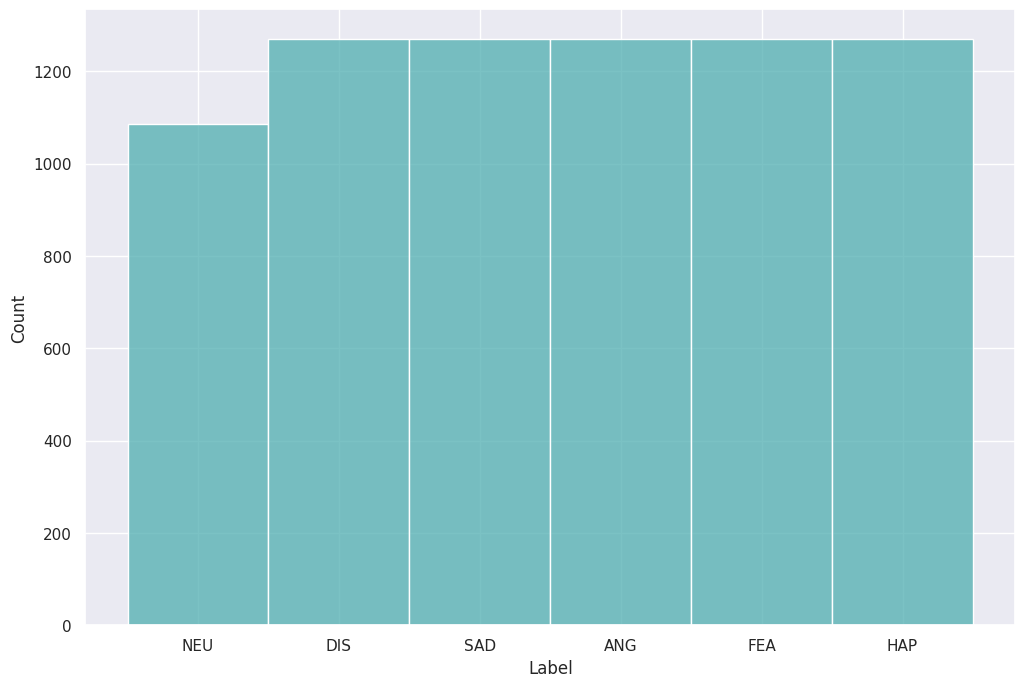

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')
sns.histplot(labels, color='#4FAEB0')

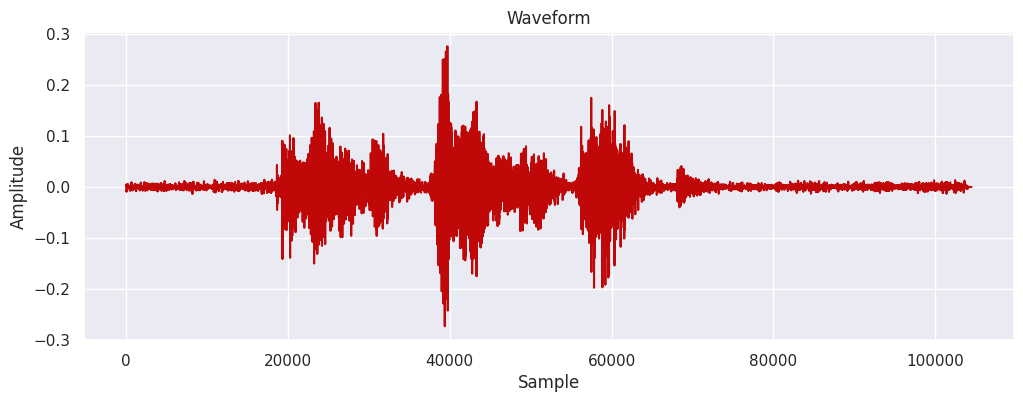

In [ ]:
import matplotlib.pyplot as plt
import IPython.display
angfile = audio_df[audio_df['Label'] == 'ANG']['Filepath']
angarray = audio_df[audio_df['Label'] == 'ANG']['Arrays']

plt.figure(figsize=(12, 4))
plt.plot(angarray.iloc[0], color='#C00808')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(angfile.iloc[0])

# CNN model

In [ ]:
import librosa
audio_arrays = []

for i in audio_df['Filepath']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)

audio_df['Arrays'] = audio_arrays
audio_df

,Filepath,Label,Arrays
0,/content/data/Crema/1012_ITH_NEU_XX.wav,NEU,"[0.0077685746, 0.008916434, 0.006772152, 0.005..."
1,/content/data/Crema/1003_IOM_DIS_XX.wav,DIS,"[-0.004708944, -0.0058163507, -0.0050836857, -..."
2,/content/data/Crema/1052_TIE_NEU_XX.wav,NEU,"[0.0051247957, 0.006485525, 0.005895991, 0.005..."
3,/content/data/Crema/1064_TSI_SAD_XX.wav,SAD,"[-0.0021401502, -0.0027028052, -0.0024305894, ..."
4,/content/data/Crema/1004_IWW_ANG_XX.wav,ANG,"[0.0036039185, 0.0044390126, 0.0039061378, 0.0..."
...,...,...,...
7437,/content/data/Crema/1054_TSI_DIS_XX.wav,DIS,"[-0.009115613, -0.011409981, -0.010301873, -0...."
7438,/content/data/Crema/1076_IWL_DIS_XX.wav,DIS,"[-1.02865e-05, -9.320102e-05, -1.3918849e-05, ..."
7439,/content/data/Crema/1059_ITS_HAP_XX.wav,HAP,"[-6.776677e-11, -2.5130299e-11, 6.359038e-11, ..."
7440,/content/data/Crema/1012_IWW_HAP_XX.wav,HAP,"[0.0013943226, 0.0017410072, 0.0015982592, 0.0..."


In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
import numpy as np
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(audio_df.Filepath,audio_df.Label,range(audio_df.Filepath.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

0it [00:00, ?it/s]


TypeError: pitch_shift() takes 1 positional argument but 3 were given

In [ ]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = audio_df.Filepath
emotions = audio_df.Label

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  833.9542944149998


In [ ]:
len(X), len(Y), audio_df.Filepath.shape

(29768, 29768, (7442,))

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.012695,0.029785,0.039551,0.046387,0.053223,0.049805,0.052734,0.052246,0.049805,0.048828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
1,0.013672,0.041504,0.054688,0.061035,0.066895,0.053223,0.056641,0.057129,0.056641,0.055664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
2,0.013184,0.029785,0.042969,0.050293,0.059570,0.055664,0.059570,0.065918,0.059570,0.058105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
3,0.014160,0.030762,0.045898,0.054199,0.064453,0.061523,0.066406,0.074707,0.067383,0.069824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
4,0.027832,0.052734,0.078125,0.085938,0.093262,0.088379,0.085449,0.084473,0.075684,0.073242,...,-5.527622,-5.654099,-15.494478,-2.401818,-9.746628,-3.719525,-3.054638,-6.010822,-10.439369,DIS


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.012695,0.029785,0.039551,0.046387,0.053223,0.049805,0.052734,0.052246,0.049805,0.048828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
1,0.013672,0.041504,0.054688,0.061035,0.066895,0.053223,0.056641,0.057129,0.056641,0.055664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
2,0.013184,0.029785,0.042969,0.050293,0.059570,0.055664,0.059570,0.065918,0.059570,0.058105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
3,0.014160,0.030762,0.045898,0.054199,0.064453,0.061523,0.066406,0.074707,0.067383,0.069824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
4,0.027832,0.052734,0.078125,0.085938,0.093262,0.088379,0.085449,0.084473,0.075684,0.073242,...,-5.527622,-5.654099,-15.494478,-2.401818,-9.746628,-3.719525,-3.054638,-6.010822,-10.439369,DIS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29763,0.079590,0.120117,0.137207,0.140137,0.164551,0.187012,0.227539,0.220703,0.192871,0.153809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
29764,0.049316,0.070801,0.087891,0.086426,0.073730,0.065918,0.061523,0.050781,0.040039,0.031738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANG
29765,0.145996,0.170410,0.187500,0.119629,0.078613,0.075684,0.076660,0.079102,0.075195,0.064941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANG
29766,0.043945,0.065430,0.085938,0.084961,0.084961,0.080078,0.074707,0.060547,0.043945,0.033203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANG


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(29768, 2377)

In [ ]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, x_test, Y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Second split: Train + Val from Temp
x_train, x_val, y_train, y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42, shuffle=True)
# x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape,x_val.shape, y_val.shape, x_test.shape, y_test.shape

((17860, 2376), (17860, 6), (5954, 2376), (5954, 6), (5954, 2376), (5954, 6))

In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_valcnn= np.expand_dims(x_val, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape,x_valcnn.shape,y_val.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((17860, 2376, 1),
 (17860, 6),
 (5954, 2376, 1),
 (5954, 6),
 (5954, 2376, 1),
 (5954, 6))

In [ ]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,07

 Total params: 7,192,710 (27.44 MB)

 Trainable params: 7,188,358 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max')
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_valcnn, y_val), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4990 - loss: 1.2693

280/280 ━━━━━━━━━━━━━━━━━━━━ 66s 235ms/step - accuracy: 0.4990 - loss: 1.2693 - val_accuracy: 0.4088 - val_loss: 1.5677 - learning_rate: 0.0010
Epoch 2/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5242 - loss: 1.2120

280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.5243 - loss: 1.2120 - val_accuracy: 0.5037 - val_loss: 1.2550 - learning_rate: 0.0010
Epoch 3/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5525 - loss: 1.1454

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.5526 - loss: 1.1453 - val_accuracy: 0.5275 - val_loss: 1.2173 - learning_rate: 0.0010
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 237ms/step - accuracy: 0.6048 - loss: 1.0290 - val_accuracy: 0.4565 - val_loss: 1.4578 - learning_rate: 0.0010
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.5852 - loss: 1.0600 - val_accuracy: 0.5126 - val_loss: 1.2863 - learning_rate: 0.0010
Epoch 6/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6823 - loss: 0.8508

280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 240ms/step - accuracy: 0.6823 - loss: 0.8508 - val_accuracy: 0.5994 - val_loss: 1.0733 - learning_rate: 0.0010
Epoch 7/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7263 - loss: 0.7316

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.7263 - loss: 0.7316 - val_accuracy: 0.6525 - val_loss: 0.9203 - learning_rate: 0.0010
Epoch 8/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7886 - loss: 0.5882

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.7886 - loss: 0.5882 - val_accuracy: 0.6685 - val_loss: 0.8963 - learning_rate: 0.0010
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 240ms/step - accuracy: 0.8170 - loss: 0.5279 - val_accuracy: 0.6060 - val_loss: 1.1156 - learning_rate: 0.0010
Epoch 10/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8388 - loss: 0.4532

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.8389 - loss: 0.4530 - val_accuracy: 0.7387 - val_loss: 0.7546 - learning_rate: 0.0010
Epoch 11/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8851 - loss: 0.3413

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.8852 - loss: 0.3411 - val_accuracy: 0.7835 - val_loss: 0.6291 - learning_rate: 0.0010
Epoch 12/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.9042 - loss: 0.2815 - val_accuracy: 0.7746 - val_loss: 0.7303 - learning_rate: 0.0010
Epoch 13/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.9395 - loss: 0.1889 - val_accuracy: 0.7796 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 14/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9364 - loss: 0.1948

280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - accuracy: 0.9364 - loss: 0.1947 - val_accuracy: 0.8336 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 15/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9278 - loss: 0.2146

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.9279 - loss: 0.2143 - val_accuracy: 0.8542 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 16/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.9599 - loss: 0.1282 - val_accuracy: 0.8250 - val_loss: 0.6030 - learning_rate: 0.0010
Epoch 17/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9717 - loss: 0.0922

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.9717 - loss: 0.0922 - val_accuracy: 0.8725 - val_loss: 0.4476 - learning_rate: 0.0010
Epoch 18/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 238ms/step - accuracy: 0.9603 - loss: 0.1201 - val_accuracy: 0.8231 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 19/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - accuracy: 0.9725 - loss: 0.0841 - val_accuracy: 0.8314 - val_loss: 0.6412 - learning_rate: 0.0010
Epoch 20/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9730 - loss: 0.0796
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.9730 - loss: 0.0797 - val_accuracy: 0.8383 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 21/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9653 - loss: 0.1079

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - accuracy: 0.9654 - loss: 0.1077 - val_accuracy: 0.8957 - val_loss: 0.4000 - learning_rate: 5.0000e-04
Epoch 22/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9914 - loss: 0.0371

280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 240ms/step - accuracy: 0.9914 - loss: 0.0370 - val_accuracy: 0.9031 - val_loss: 0.3696 - learning_rate: 5.0000e-04
Epoch 23/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9937 - loss: 0.0269

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.9937 - loss: 0.0269 - val_accuracy: 0.9091 - val_loss: 0.3632 - learning_rate: 5.0000e-04
Epoch 24/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.9908 - loss: 0.0335 - val_accuracy: 0.8975 - val_loss: 0.3886 - learning_rate: 5.0000e-04
Epoch 25/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.9735 - loss: 0.0827 - val_accuracy: 0.8908 - val_loss: 0.4373 - learning_rate: 5.0000e-04
Epoch 26/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9831 - loss: 0.0551
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.9832 - loss: 0.0550 - val_accuracy: 0.9007 - val_loss: 0.3949 - learning_rate: 5.0000e-04
Epoch 27/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9891 - loss: 0.0384

280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.9892 - loss: 0.0383 - val_accuracy: 0.9164 - val_loss: 0.3492 - learning_rate: 2.5000e-04
Epoch 28/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9936 - loss: 0.0261

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.9936 - loss: 0.0261 - val_accuracy: 0.9175 - val_loss: 0.3349 - learning_rate: 2.5000e-04
Epoch 29/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9948 - loss: 0.0218

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.9948 - loss: 0.0218 - val_accuracy: 0.9182 - val_loss: 0.3348 - learning_rate: 2.5000e-04
Epoch 30/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9973 - loss: 0.0141

280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 240ms/step - accuracy: 0.9973 - loss: 0.0141 - val_accuracy: 0.9226 - val_loss: 0.3315 - learning_rate: 2.5000e-04
Epoch 31/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 240ms/step - accuracy: 0.9973 - loss: 0.0113 - val_accuracy: 0.9175 - val_loss: 0.3422 - learning_rate: 2.5000e-04
Epoch 32/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 238ms/step - accuracy: 0.9963 - loss: 0.0153 - val_accuracy: 0.9202 - val_loss: 0.3378 - learning_rate: 2.5000e-04
Epoch 33/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9961 - loss: 0.0168
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.9961 - loss: 0.0168 - val_accuracy: 0.9187 - val_loss: 0.3399 - learning_rate: 2.5000e-04
Epoch 34/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.9984 - loss: 0.0109 - val_accuracy: 0.9179 - val_loss: 0.3451 - learning_rate: 1.2500e-04
Epoch 35/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - 

In [ ]:
print(len(train_loss))

35


187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9173 - loss: 0.3464
Accuracy of our model on test data :  92.19012260437012 %


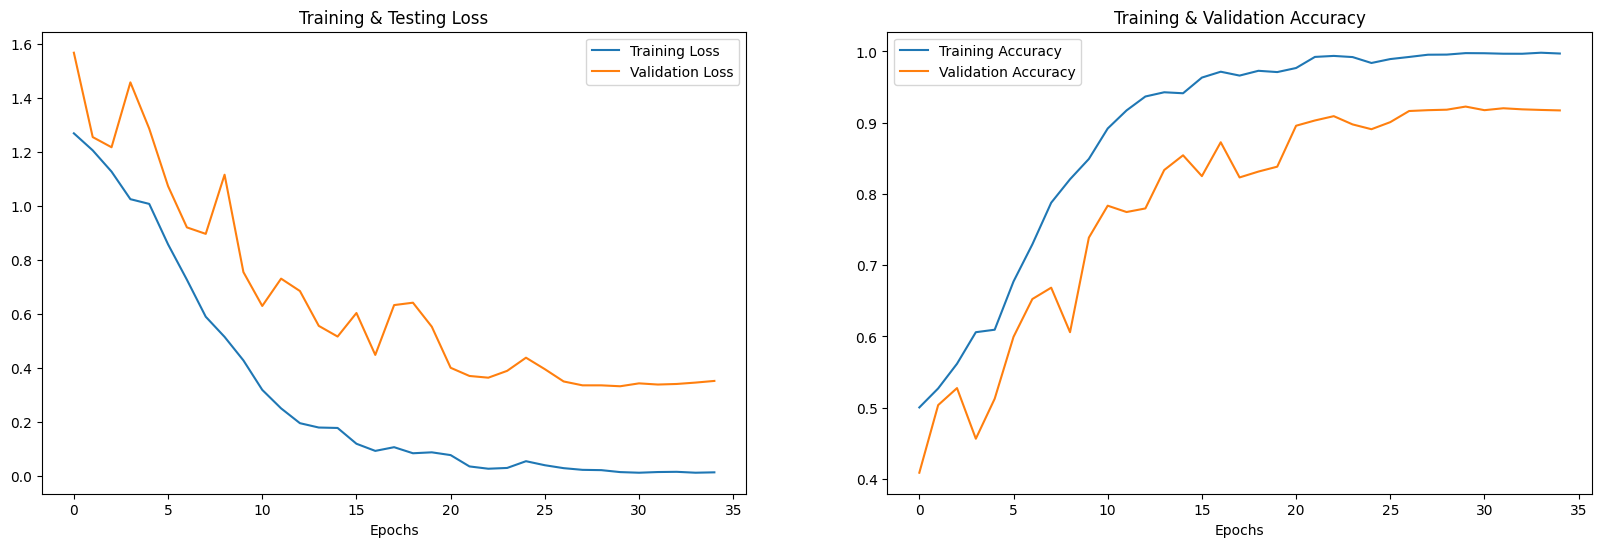

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(35)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss , label = 'Training Loss')
ax[0].plot(epochs, val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc , label = 'Training Accuracy')
ax[1].plot(epochs, val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step


,Predicted Labels,Actual Labels
0,NEU,FEA
1,SAD,SAD
2,FEA,FEA
3,SAD,SAD
4,ANG,ANG
5,FEA,FEA
6,ANG,ANG
7,DIS,DIS
8,ANG,ANG
9,FEA,FEA


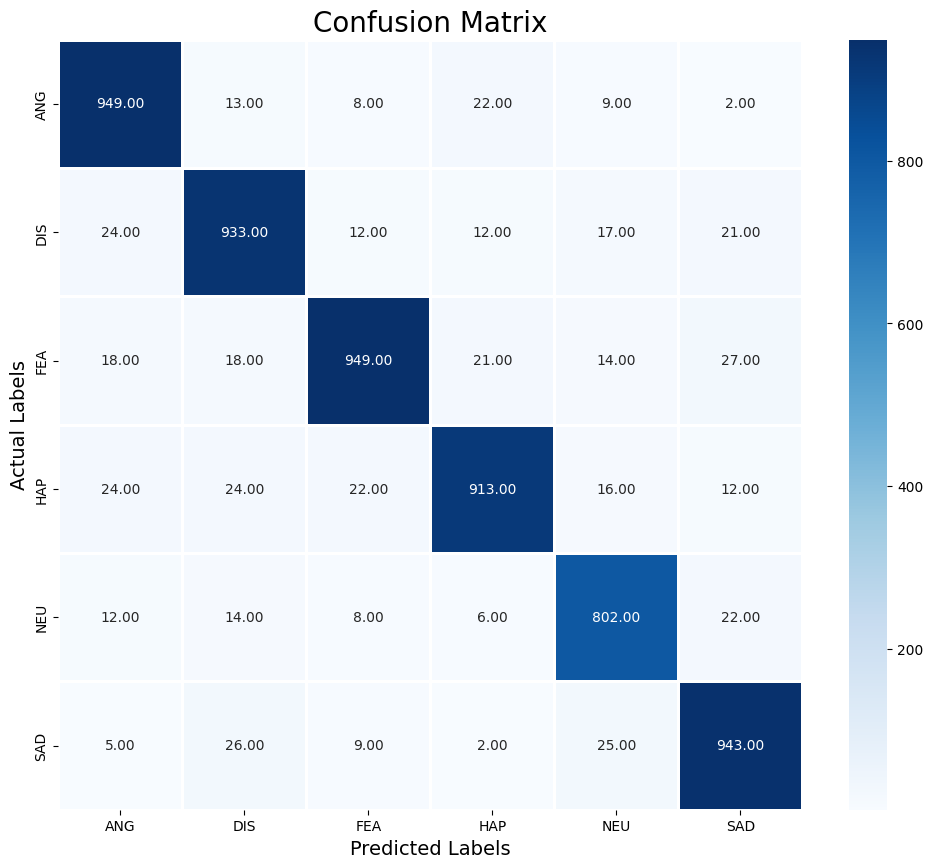

              precision    recall  f1-score   support

         ANG       0.92      0.95      0.93      1003
         DIS       0.91      0.92      0.91      1019
         FEA       0.94      0.91      0.92      1047
         HAP       0.94      0.90      0.92      1011
         NEU       0.91      0.93      0.92       864
         SAD       0.92      0.93      0.93      1010

    accuracy                           0.92      5954
   macro avg       0.92      0.92      0.92      5954
weighted avg       0.92      0.92      0.92      5954



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Using LLM

In [ ]:
pip install SpeechRecognition pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 56.0 MB/s eta 0:00:00


In [ ]:
import speech_recognition as sr
from pydub import AudioSegment

def convert_to_wav(input_file, output_file='converted.wav'):
    """Convert mp3 or other formats to wav using pydub."""
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format='wav')
    return output_file

def speech_to_text_from_file(file_path):
    recognizer = sr.Recognizer()

    # Convert if not a wav file
    if not file_path.endswith(".wav"):
        print("Converting to WAV format...")
        file_path = convert_to_wav(file_path)

    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)

    try:
        print("Recognizing speech...")
        text = recognizer.recognize_google(audio_data)
        print("Transcription: ", text)
        return text
    except sr.UnknownValueError:
        print("Could not understand the audio.")
    except sr.RequestError as e:
        print(f"Error with the recognition service: {e}")

# if __name__ == "__main__":
#     path_to_audio = "your_audio_file.mp3"  # Change this to your file name
#     speech_to_text_from_file(path_to_audio)

In [ ]:
audio_df2 = audio_df.copy()[:25]
audio_df2['SpeechRectext'] = audio_df2.apply(lambda row: speech_to_text_from_file(row['Filepath']), axis=1)

Recognizing speech...
Transcription:  I think I have a doctor's appointment
Recognizing speech...
Transcription:  I'm on my way to the meeting
Recognizing speech...
Transcription:  that is exactly what happened
Recognizing speech...
Transcription:  the surface is slick
Recognizing speech...
Transcription:  I wonder what this is about
Recognizing speech...
Transcription:  I would like a new alarm clock
Recognizing speech...
Transcription:  that is exactly what happened
Recognizing speech...
Transcription:  it's 11:00
Recognizing speech...
Transcription:  I think I have a doctor's appointment
Recognizing speech...
Transcription:  I'm on my way to the meeting
Recognizing speech...
Transcription:  it's 11:00
Recognizing speech...
Transcription:  don't forget a jacket
Recognizing speech...
Transcription:  I wonder what this is about
Recognizing speech...
Could not understand the audio.
Recognizing speech...
Could not understand the audio.
Recognizing speech...
Transcription:  don't forget a

In [ ]:
audio_df2

,Filepath,Label,Arrays,SpeechRectext
0,/content/data/Crema/1012_ITH_NEU_XX.wav,NEU,"[0.0077685746, 0.008916434, 0.006772152, 0.005...",I think I have a doctor's appointment
1,/content/data/Crema/1003_IOM_DIS_XX.wav,DIS,"[-0.004708944, -0.0058163507, -0.0050836857, -...",I'm on my way to the meeting
2,/content/data/Crema/1052_TIE_NEU_XX.wav,NEU,"[0.0051247957, 0.006485525, 0.005895991, 0.005...",that is exactly what happened
3,/content/data/Crema/1064_TSI_SAD_XX.wav,SAD,"[-0.0021401502, -0.0027028052, -0.0024305894, ...",the surface is slick
4,/content/data/Crema/1004_IWW_ANG_XX.wav,ANG,"[0.0036039185, 0.0044390126, 0.0039061378, 0.0...",I wonder what this is about
5,/content/data/Crema/1012_IWL_DIS_XX.wav,DIS,"[-0.0006681449, -0.000727192, -0.0004511163, -...",I would like a new alarm clock
6,/content/data/Crema/1058_TIE_ANG_XX.wav,ANG,"[0.0017541726, 0.0026575632, 0.0029656827, 0.0...",that is exactly what happened
7,/content/data/Crema/1024_IEO_SAD_MD.wav,SAD,"[-0.0037392552, -0.004252677, -0.003161763, -0...",it's 11:00
8,/content/data/Crema/1044_ITH_DIS_XX.wav,DIS,"[0.0042331917, 0.0055054766, 0.0052368566, 0.0...",I think I have a doctor's appointment
9,/content/data/Crema/1001_IOM_FEA_XX.wav,FEA,"[0.0074747074, 0.009228159, 0.007966678, 0.006...",I'm on my way to the meeting


In [ ]:
audio_df2 = audio_df.copy()[:50]
audio_df2['SpeechRectext'] = audio_df2.apply(lambda row: speech_to_text_from_file(row['Filepath']), axis=1)

Recognizing speech...
Transcription:  I think I have a doctor's appointment
Recognizing speech...
Transcription:  I'm on my way to the meeting
Recognizing speech...
Transcription:  that is exactly what happened
Recognizing speech...
Transcription:  the surface is slick
Recognizing speech...
Transcription:  I wonder what this is about
Recognizing speech...
Transcription:  I would like a new alarm clock
Recognizing speech...
Transcription:  that is exactly what happened
Recognizing speech...
Transcription:  it's 11:00
Recognizing speech...
Transcription:  I think I have a doctor's appointment
Recognizing speech...
Transcription:  I'm on my way to the meeting
Recognizing speech...
Transcription:  it's 11:00
Recognizing speech...
Transcription:  don't forget a jacket
Recognizing speech...
Transcription:  I wonder what this is about
Recognizing speech...
Could not understand the audio.
Recognizing speech...
Could not understand the audio.
Recognizing speech...
Transcription:  don't forget a

In [ ]:
audio_df2

,Filepath,Label,Arrays,SpeechRectext
0,/content/data/Crema/1012_ITH_NEU_XX.wav,NEU,"[0.0077685746, 0.008916434, 0.006772152, 0.005...",I think I have a doctor's appointment
1,/content/data/Crema/1003_IOM_DIS_XX.wav,DIS,"[-0.004708944, -0.0058163507, -0.0050836857, -...",I'm on my way to the meeting
2,/content/data/Crema/1052_TIE_NEU_XX.wav,NEU,"[0.0051247957, 0.006485525, 0.005895991, 0.005...",that is exactly what happened
3,/content/data/Crema/1064_TSI_SAD_XX.wav,SAD,"[-0.0021401502, -0.0027028052, -0.0024305894, ...",the surface is slick
4,/content/data/Crema/1004_IWW_ANG_XX.wav,ANG,"[0.0036039185, 0.0044390126, 0.0039061378, 0.0...",I wonder what this is about
5,/content/data/Crema/1012_IWL_DIS_XX.wav,DIS,"[-0.0006681449, -0.000727192, -0.0004511163, -...",I would like a new alarm clock
6,/content/data/Crema/1058_TIE_ANG_XX.wav,ANG,"[0.0017541726, 0.0026575632, 0.0029656827, 0.0...",that is exactly what happened
7,/content/data/Crema/1024_IEO_SAD_MD.wav,SAD,"[-0.0037392552, -0.004252677, -0.003161763, -0...",it's 11:00
8,/content/data/Crema/1044_ITH_DIS_XX.wav,DIS,"[0.0042331917, 0.0055054766, 0.0052368566, 0.0...",I think I have a doctor's appointment
9,/content/data/Crema/1001_IOM_FEA_XX.wav,FEA,"[0.0074747074, 0.009228159, 0.007966678, 0.006...",I'm on my way to the meeting


In [ ]:
import librosa
import numpy as np

def extract_pitch(audio_path, sr=44100, fmin=50.0, fmax=2000.0):
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)

    # Extract pitch using librosa's pyin
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y,
        sr=sr,
        fmin=fmin,
        fmax=fmax
    )

    # Remove unvoiced (NaN) values
    pitch_values = f0[~np.isnan(f0)]

    return pitch_values, sr

audio_arrays = []
for i in audio_df2['Filepath']:
  pitch, sr = extract_pitch(i)
  mean_pitch = np.mean(pitch) if len(pitch) > 0 else 0
  print("Mean pitch (Hz):", mean_pitch)
  audio_arrays.append(mean_pitch)

audio_df2['Pitch'] = audio_arrays

Mean pitch (Hz): 228.4317093759296
Mean pitch (Hz): 171.9448195174238
Mean pitch (Hz): 177.73490600808924
Mean pitch (Hz): 155.57581943030482
Mean pitch (Hz): 205.8969177291981
Mean pitch (Hz): 206.89653889207696
Mean pitch (Hz): 254.71992238082117
Mean pitch (Hz): 179.55317390703502
Mean pitch (Hz): 109.20878473756945
Mean pitch (Hz): 118.86306498725709
Mean pitch (Hz): 111.39482556932455
Mean pitch (Hz): 0
Mean pitch (Hz): 220.31842695086627
Mean pitch (Hz): 147.88281816869798
Mean pitch (Hz): 141.31674608628808
Mean pitch (Hz): 192.9570772630401
Mean pitch (Hz): 195.49418027945154
Mean pitch (Hz): 217.51430466065202
Mean pitch (Hz): 131.1836440052743
Mean pitch (Hz): 195.45354138608505
Mean pitch (Hz): 193.40405934428478
Mean pitch (Hz): 188.11826288459886
Mean pitch (Hz): 95.01046845080887
Mean pitch (Hz): 382.79585354888803
Mean pitch (Hz): 249.6828071867291


In [ ]:
pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.8 MB/s eta 0:00:00


In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain.tools import Tool
from openai import AzureOpenAI
from tenacity import wait_exponential, retry, stop_after_attempt
from typing import List, Dict
import os
import json
import pandas as pd
import itertools
from datetime import datetime

if "AZURE_OPENAI_API_KEY" not in os.environ:
    os.environ["AZURE_OPENAI_API_KEY"] = "xxxxx"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://xxxx.openai.azure.com/"

class GenAIInterface:
    """
    A class to interact with the GenAI model using the OpenAI API.

    Attributes:
        api_key (str): The OpenAI API key.
        api_base (str): The OpenAI API base URL.
        api_type (str): The API type.
        api_version (str): The API version.
        deployment_name (str): The deployment name for the model.
    """

    def __init__(self, api_key=os.environ['AZURE_OPENAI_API_KEY'], api_base=os.environ["AZURE_OPENAI_ENDPOINT"], api_type='azure',
                 api_version="2024-12-01-preview", deployment_name='gpt-4o'): #2024-02-15-preview #gpt-4o
        """
        Initializes the GenAIInterface class.

        Args:
            api_key (str, optional): The OpenAI API key. Defaults to the value from configs.
            api_base (str, optional): The OpenAI API base URL. Defaults to the value from configs.
            api_type (str, optional): The API type. Defaults to the value from configs.
            api_version (str, optional): The API version. Defaults to the value from configs.
            deployment_name (str, optional): The deployment name for the model. Defaults to the value from configs.
        """
        self.client = AzureOpenAI(
            api_key="xxxx",#api_key,
            api_version=api_version,
            azure_endpoint="https://xxxx.openai.azure.com/",#api_base
        )
        self.deployment_name = deployment_name

    @retry(wait=wait_exponential(multiplier=1, min=4, max=10), stop=stop_after_attempt(5))
    def generate_response(self, messages:List[Dict[str, str]]):
        """
        Generates a message using the GenAI model.

        Args:
            messages (list): A list of message objects.

        Returns:
            str: The generated message.
        """

        response = self.client.chat.completions.create(
            model=self.deployment_name,
            messages=messages,
            #temperature=0,
            #max_completion_tokens=100000,  #for o3-mini
            max_tokens=16000,   #for gpt-4o
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None
        )

        if response is not None:
            return response.choices[0].message.content
        else:
            raise Exception("The server is down. Please try again later.")

    @retry(wait=wait_exponential(multiplier=1, min=4, max=10), stop=stop_after_attempt(5))
    def generate_response_json(self, messages:List[Dict[str, str]]):
        """
        Generates a message using the GenAI model.

        Args:
            messages (list): A list of message objects.

        Returns:
            str: The generated message.
        """

        response = self.client.chat.completions.create(
            model=self.deployment_name,
            messages=messages,
            #temperature=0,
            #max_completion_tokens=100000, #for o3-mini
            max_tokens=16000,   #for gpt-4o
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None,
            response_format={"type": "json_object"}
        )

        if response is not None:
            return response.choices[0].message.content
        else:
            raise Exception("The server is down. Please try again later.")

In [ ]:
def get_llm_output(prompt):
  genai = GenAIInterface()
  message=[{"role": "system", "content": "You are an assistant that analyzes speech emotions."},{"role": "user", "content": prompt}]
  return genai.generate_response(message)

In [ ]:
for i,row in audio_df2.iterrows():
  prompt = f"""
You are an expert in speech emotion recognition.

Examples:
Sentence: 'I can't believe this happened!' | Pitch: 290.5 Hz → ANGRY
Sentence: 'I’m looking forward to the party!' | Pitch: 260.1 Hz → HAPPY
Sentence: 'I’m fine, I guess' | Pitch: 155.0 Hz → SAD
Sentence: 'I'm on my way to the meeting' | Pitch: 171.94 Hz → DISGUST

Now, classify the emotion in the following:
Sentence: '{row['SpeechRectext']}'
Pitch: {row['Pitch']} Hz

Use both the text and pitch. A higher pitch may indicate heightened emotions like anger or happiness, while lower pitch can suggest sadness or neutrality.
Respond with one of: ANGRY, DISGUST, FEAR, HAPPY, NEUTRAL, or SAD.
"""

  audio_df2.at[i, 'PredictedEmotion'] = get_llm_output(prompt)

In [ ]:
audio_df2#.to_excel('predictied2.xlsx')

,Filepath,Label,Arrays,SpeechRectext,PredictedEmotion,Pitch
0,/content/data/Crema/1012_ITH_NEU_XX.wav,NEU,"[0.0077685746, 0.008916434, 0.006772152, 0.005...",I think I have a doctor's appointment,Sentence: 'I think I have a doctor's appointme...,228.431709
1,/content/data/Crema/1003_IOM_DIS_XX.wav,DIS,"[-0.004708944, -0.0058163507, -0.0050836857, -...",I'm on my way to the meeting,"Based on the text ""I'm on my way to the meetin...",171.944820
2,/content/data/Crema/1052_TIE_NEU_XX.wav,NEU,"[0.0051247957, 0.006485525, 0.005895991, 0.005...",that is exactly what happened,Sentence: 'that is exactly what happened' \nP...,177.734906
3,/content/data/Crema/1064_TSI_SAD_XX.wav,SAD,"[-0.0021401502, -0.0027028052, -0.0024305894, ...",the surface is slick,Sentence: 'the surface is slick' \nPitch: 155...,155.575819
4,/content/data/Crema/1004_IWW_ANG_XX.wav,ANG,"[0.0036039185, 0.0044390126, 0.0039061378, 0.0...",I wonder what this is about,Sentence: 'I wonder what this is about' \nPit...,205.896918
5,/content/data/Crema/1012_IWL_DIS_XX.wav,DIS,"[-0.0006681449, -0.000727192, -0.0004511163, -...",I would like a new alarm clock,Sentence: 'I would like a new alarm clock' \n...,206.896539
6,/content/data/Crema/1058_TIE_ANG_XX.wav,ANG,"[0.0017541726, 0.0026575632, 0.0029656827, 0.0...",that is exactly what happened,Sentence: 'that is exactly what happened' \nP...,254.719922
7,/content/data/Crema/1024_IEO_SAD_MD.wav,SAD,"[-0.0037392552, -0.004252677, -0.003161763, -0...",it's 11:00,Sentence: 'it's 11:00' \nPitch: 179.553173907...,179.553174
8,/content/data/Crema/1044_ITH_DIS_XX.wav,DIS,"[0.0042331917, 0.0055054766, 0.0052368566, 0.0...",I think I have a doctor's appointment,Sentence: 'I think I have a doctor's appointme...,109.208785
9,/content/data/Crema/1001_IOM_FEA_XX.wav,FEA,"[0.0074747074, 0.009228159, 0.007966678, 0.006...",I'm on my way to the meeting,Sentence: 'I'm on my way to the meeting' \nPi...,118.863065


# CNN + Text Embedding

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

filepaths = audio_df['Filepath'].tolist()
with ProcessPoolExecutor() as executor:
    transcriptions = list(tqdm(executor.map(speech_to_text_from_file, filepaths), total=len(filepaths)))

audio_df['SpeechRectext'] = transcriptions

100%|██████████| 7442/7442 [40:23<00:00,  3.07it/s]


In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load the smaller model (all-MiniLM-L6-v2)
text_embedder = SentenceTransformer('all-MiniLM-L6-v2')

def get_text_embeddings_batch(text_list, batch_size=100, model=None):
    all_embeddings = []

    # Process the text in batches
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        cleaned_batch = ["" if t is None else str(t) for t in batch]

        # Get embeddings for the current batch
        embeddings = model.encode(cleaned_batch, show_progress_bar=True)

        all_embeddings.extend(embeddings)

    return all_embeddings

# Ensure that missing values are replaced with "empty" text
audio_df['SpeechRectext'] = audio_df['SpeechRectext'].where(audio_df['SpeechRectext'].notna(), "empty")

# Convert to list of texts
texts = audio_df['SpeechRectext'].tolist()

# Get embeddings for all texts using the new model
text_embeddings = get_text_embeddings_batch(texts, batch_size=100, model=text_embedder)

# Add embeddings to the dataframe
audio_df['text_embedding'] = text_embeddings


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
audio_df

,Filepath,Label,Arrays,SpeechRectext,text_embedding
0,/content/data/Crema/1068_IWW_DIS_XX.wav,DIS,[-4.0618945e-03 -5.1282770e-03 -4.6315468e-03 ...,empty,"[0.07079878, 0.03528525, -0.05698759, 0.100980..."
1,/content/data/Crema/1047_ITH_FEA_XX.wav,FEA,[-4.2736642e-03 -5.5039148e-03 -5.2730828e-03 ...,I think I have a doctor's appointment,"[0.0010545728, -0.08207063, 0.024142798, 0.038..."
2,/content/data/Crema/1081_MTI_NEU_XX.wav,NEU,[ 0.00502934 0.00631339 0.00571868 ... -0.00...,maybe tomorrow it will be cold,"[-0.08527998, 0.0010706107, 0.13346483, 0.0618..."
3,/content/data/Crema/1048_IOM_ANG_XX.wav,ANG,[1.7066014e-03 1.9116965e-03 1.3549237e-03 ......,I'm on my way to the meeting,"[-0.042649433, -0.06447795, -0.030704167, 0.06..."
4,/content/data/Crema/1032_ITS_FEA_XX.wav,FEA,[-4.2301677e-03 -5.2816542e-03 -4.6589496e-03 ...,think I've seen this before,"[-0.0823985, -0.042669315, -0.049165662, 0.014..."
...,...,...,...,...,...
7437,/content/data/Crema/1089_IOM_HAP_XX.wav,HAP,[-2.3273330e-03 -3.1216205e-03 -3.1452985e-03 ...,I'm on my way to the meeting,"[-0.042649433, -0.06447795, -0.030704167, 0.06..."
7438,/content/data/Crema/1040_IWL_HAP_XX.wav,HAP,[-4.3051834e-03 -5.1924065e-03 -4.4347728e-03 ...,I would like a new alarm clock,"[-0.075760655, 0.0031181474, 0.0070276447, 0.0..."
7439,/content/data/Crema/1007_IEO_SAD_MD.wav,SAD,[ 3.1672043e-03 4.4276686e-03 4.6713958e-03 ...,it's 11:00,"[-0.02393752, 0.037352964, -0.037225902, -0.05..."
7440,/content/data/Crema/1028_TSI_DIS_XX.wav,DIS,[ 5.1987115e-03 6.7456197e-03 6.5078777e-03 ...,the surface is slick,"[-0.05610641, -0.033631172, 0.07675455, -0.002..."


In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
import numpy as np
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    # if flatten:
    #     # Return summary statistics: mean and std of each MFCC coefficient
    #     mean_mfcc = np.mean(mfcc.T, axis=0)
    #     std_mfcc = np.std(mfcc.T, axis=0)
    #     return np.concatenate((mean_mfcc, std_mfcc))  # shape (40,)
    # else:
    #     return mfcc.T
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512,text_embed=None):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))

    # Text embedding (if transcript available)
    if text_embed is not None:
        #text_embed = np.array(get_text_embedding(text))
        result = np.hstack((result, np.array(text_embed)))
    else:
      result = np.hstack((result, np.zeros(384)))

    return result

def get_features(path,text_embed=None,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,text_embed=text_embed)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio,text_embed=text_embed)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio,text_embed=text_embed)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio,text_embed=text_embed)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [ ]:
from joblib import Parallel, delayed
import timeit

start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion,text_embed):
    features = get_features(path,text_embed)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = audio_df.Filepath
emotions = audio_df.Label
texts = [
    embedding if text != 'empty' else None
    for text, embedding in zip(audio_df['SpeechRectext'], audio_df['text_embedding'])
]

# Run the loop in parallel
results = Parallel(n_jobs=2)(delayed(process_feature)(path, emotion,text_embed) for (path, emotion,text_embed) in zip(paths, emotions,texts))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  455.6241245870001


In [ ]:
len(X), len(Y), audio_df.Filepath.shape

(29768, 29768, (7442,))

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion2.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2751,2752,2753,2754,2755,2756,2757,2758,2759,Emotions
0,0.029297,0.038574,0.051270,0.045898,0.044922,0.041992,0.036133,0.033691,0.028809,0.035645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
1,0.029297,0.038574,0.051270,0.045898,0.044922,0.042969,0.037109,0.036621,0.034668,0.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
2,0.033203,0.043945,0.056152,0.051270,0.045898,0.045898,0.041992,0.038574,0.040039,0.042480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
3,0.037109,0.050781,0.073730,0.078613,0.081055,0.098633,0.098633,0.106934,0.109375,0.099121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
4,0.011719,0.028809,0.039062,0.037109,0.037598,0.028320,0.027344,0.034180,0.036133,0.034668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEA


In [ ]:
Emotions = pd.read_csv('./emotion2.csv')
Emotions

,0,1,2,3,4,5,6,7,8,9,...,2751,2752,2753,2754,2755,2756,2757,2758,2759,Emotions
0,0.029297,0.038574,0.051270,0.045898,0.044922,0.041992,0.036133,0.033691,0.028809,0.035645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
1,0.029297,0.038574,0.051270,0.045898,0.044922,0.042969,0.037109,0.036621,0.034668,0.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
2,0.033203,0.043945,0.056152,0.051270,0.045898,0.045898,0.041992,0.038574,0.040039,0.042480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
3,0.037109,0.050781,0.073730,0.078613,0.081055,0.098633,0.098633,0.106934,0.109375,0.099121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
4,0.011719,0.028809,0.039062,0.037109,0.037598,0.028320,0.027344,0.034180,0.036133,0.034668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29763,0.123535,0.170898,0.221680,0.235840,0.247070,0.261230,0.234863,0.175781,0.112305,0.062012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
29764,0.162109,0.187500,0.204102,0.146484,0.080078,0.066895,0.059082,0.045410,0.039551,0.050293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANG
29765,0.159180,0.184570,0.201172,0.143555,0.080078,0.066895,0.058105,0.044434,0.038574,0.049316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANG
29766,0.147949,0.166504,0.188477,0.132324,0.079590,0.072754,0.061035,0.049316,0.052246,0.056152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANG


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2756        False
2757        False
2758        False
2759        False
Emotions    False
Length: 2761, dtype: bool


(29768, 2761)

In [ ]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, x_test, Y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Second split: Train + Val from Temp
x_train, x_val, y_train, y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape,x_val.shape, y_val.shape, x_test.shape, y_test.shape

((17860, 2760), (17860, 6), (5954, 2760), (5954, 6), (5954, 2760), (5954, 6))

In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_valcnn= np.expand_dims(x_val, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape,x_valcnn.shape,y_val.shape, x_testcnn.shape, y_test.shape

((17860, 2760, 1),
 (17860, 6),
 (5954, 2760, 1),
 (5954, 6),
 (5954, 2760, 1),
 (5954, 6))

In [ ]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2760, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2760, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1380, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1380, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1380, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 690, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 690, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 690, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 690, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 345, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 345, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 345, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 173, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 173, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 173, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 173, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 87, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 87, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,702,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,07

 Total params: 7,979,142 (30.44 MB)

 Trainable params: 7,974,790 (30.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model2_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    mode='max')
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_valcnn, y_val), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3325 - loss: 1.9034

280/280 ━━━━━━━━━━━━━━━━━━━━ 103s 300ms/step - accuracy: 0.3326 - loss: 1.9024 - val_accuracy: 0.1994 - val_loss: 1.8117 - learning_rate: 0.0010
Epoch 2/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4269 - loss: 1.4310

280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.4269 - loss: 1.4309 - val_accuracy: 0.3134 - val_loss: 1.7149 - learning_rate: 0.0010
Epoch 3/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.4589 - loss: 1.3721

280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - accuracy: 0.4589 - loss: 1.3719 - val_accuracy: 0.4735 - val_loss: 1.3071 - learning_rate: 0.0010
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.4955 - loss: 1.2715 - val_accuracy: 0.4118 - val_loss: 1.4271 - learning_rate: 0.0010
Epoch 5/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5299 - loss: 1.1998

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.5300 - loss: 1.1997 - val_accuracy: 0.4780 - val_loss: 1.3320 - learning_rate: 0.0010
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 265ms/step - accuracy: 0.5614 - loss: 1.1207 - val_accuracy: 0.3725 - val_loss: 1.8913 - learning_rate: 0.0010
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.4506 - loss: 1.4021 - val_accuracy: 0.4745 - val_loss: 1.3506 - learning_rate: 0.0010
Epoch 8/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5780 - loss: 1.0814

280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 266ms/step - accuracy: 0.5781 - loss: 1.0814 - val_accuracy: 0.4926 - val_loss: 1.3513 - learning_rate: 0.0010
Epoch 9/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6299 - loss: 0.9657

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.6299 - loss: 0.9657 - val_accuracy: 0.5763 - val_loss: 1.1045 - learning_rate: 0.0010
Epoch 10/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6712 - loss: 0.8747

280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 266ms/step - accuracy: 0.6712 - loss: 0.8747 - val_accuracy: 0.5875 - val_loss: 1.1143 - learning_rate: 0.0010
Epoch 11/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.7256 - loss: 0.7463 - val_accuracy: 0.5615 - val_loss: 1.1996 - learning_rate: 0.0010
Epoch 12/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7757 - loss: 0.6212

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.7757 - loss: 0.6212 - val_accuracy: 0.6003 - val_loss: 1.2068 - learning_rate: 0.0010
Epoch 13/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7019 - loss: 0.8005

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.7022 - loss: 0.7998 - val_accuracy: 0.6344 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 14/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.8363 - loss: 0.4649 - val_accuracy: 0.6213 - val_loss: 1.1205 - learning_rate: 0.0010
Epoch 15/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8469 - loss: 0.4237

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.8471 - loss: 0.4233 - val_accuracy: 0.7801 - val_loss: 0.6517 - learning_rate: 0.0010
Epoch 16/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.9079 - loss: 0.2729 - val_accuracy: 0.7570 - val_loss: 0.7414 - learning_rate: 0.0010
Epoch 17/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.8699 - loss: 0.3723 - val_accuracy: 0.6814 - val_loss: 1.0510 - learning_rate: 0.0010
Epoch 18/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8599 - loss: 0.3924

280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 266ms/step - accuracy: 0.8601 - loss: 0.3918 - val_accuracy: 0.8065 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 19/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9535 - loss: 0.1470

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.9535 - loss: 0.1470 - val_accuracy: 0.8493 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 20/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 264ms/step - accuracy: 0.9709 - loss: 0.0998 - val_accuracy: 0.8257 - val_loss: 0.5736 - learning_rate: 0.0010
Epoch 21/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.8871 - loss: 0.3259 - val_accuracy: 0.8446 - val_loss: 0.5242 - learning_rate: 0.0010
Epoch 22/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9627 - loss: 0.1198

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.9627 - loss: 0.1198 - val_accuracy: 0.8680 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 23/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9746 - loss: 0.0818

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.9746 - loss: 0.0818 - val_accuracy: 0.8702 - val_loss: 0.4889 - learning_rate: 0.0010
Epoch 24/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.9532 - loss: 0.1344 - val_accuracy: 0.8653 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 25/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.9734 - loss: 0.0852 - val_accuracy: 0.8462 - val_loss: 0.5507 - learning_rate: 0.0010
Epoch 26/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9065 - loss: 0.2792
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - accuracy: 0.9067 - loss: 0.2786 - val_accuracy: 0.8551 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 27/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9839 - loss: 0.0533

280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - accuracy: 0.9839 - loss: 0.0533 - val_accuracy: 0.8944 - val_loss: 0.3990 - learning_rate: 5.0000e-04
Epoch 28/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9924 - loss: 0.0330

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.9924 - loss: 0.0329 - val_accuracy: 0.9006 - val_loss: 0.3888 - learning_rate: 5.0000e-04
Epoch 29/50
 14/280 ━━━━━━━━━━━━━━━━━━━━ 1:05 245ms/step - accuracy: 0.9936 - loss: 0.0281

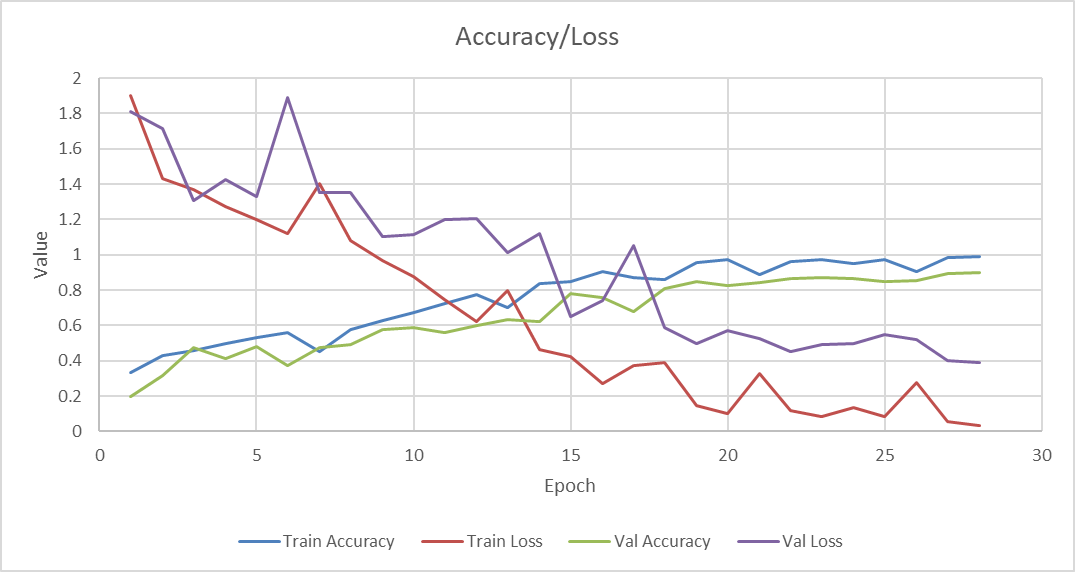

In [ ]:
model.load_weights('best_model2_weights.h5')

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_valcnn, y_val), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9742 - loss: 0.0772

280/280 ━━━━━━━━━━━━━━━━━━━━ 102s 297ms/step - accuracy: 0.9742 - loss: 0.0772 - val_accuracy: 0.8477 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 75s 269ms/step - accuracy: 0.9757 - loss: 0.0779 - val_accuracy: 0.8055 - val_loss: 0.7708 - learning_rate: 0.0010
Epoch 3/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9796 - loss: 0.0615

280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 271ms/step - accuracy: 0.9796 - loss: 0.0615 - val_accuracy: 0.8661 - val_loss: 0.5405 - learning_rate: 0.0010
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9706 - loss: 0.0868 - val_accuracy: 0.8129 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 5/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9469 - loss: 0.1561

280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 288ms/step - accuracy: 0.9470 - loss: 0.1558 - val_accuracy: 0.8784 - val_loss: 0.5090 - learning_rate: 0.0010
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 77s 269ms/step - accuracy: 0.9861 - loss: 0.0457 - val_accuracy: 0.8713 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 7/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9806 - loss: 0.0573

280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 270ms/step - accuracy: 0.9806 - loss: 0.0573 - val_accuracy: 0.8885 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9843 - loss: 0.0507 - val_accuracy: 0.8255 - val_loss: 0.7508 - learning_rate: 0.0010
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9897 - loss: 0.0332 - val_accuracy: 0.8658 - val_loss: 0.5361 - learning_rate: 0.0010
Epoch 10/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9884 - loss: 0.0355
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9884 - loss: 0.0356 - val_accuracy: 0.8611 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 11/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9897 - loss: 0.0311

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9897 - loss: 0.0311 - val_accuracy: 0.9105 - val_loss: 0.4051 - learning_rate: 5.0000e-04
Epoch 12/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.8979 - val_loss: 0.4318 - learning_rate: 5.0000e-04
Epoch 13/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9944 - loss: 0.0187

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9944 - loss: 0.0187 - val_accuracy: 0.9122 - val_loss: 0.3991 - learning_rate: 5.0000e-04
Epoch 14/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9926 - loss: 0.0290 - val_accuracy: 0.9112 - val_loss: 0.4134 - learning_rate: 5.0000e-04
Epoch 15/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9873 - loss: 0.0382 - val_accuracy: 0.9090 - val_loss: 0.4036 - learning_rate: 5.0000e-04
Epoch 16/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9943 - loss: 0.0188

280/280 ━━━━━━━━━━━━━━━━━━━━ 87s 289ms/step - accuracy: 0.9943 - loss: 0.0188 - val_accuracy: 0.9172 - val_loss: 0.4004 - learning_rate: 5.0000e-04
Epoch 17/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9954 - loss: 0.0167

280/280 ━━━━━━━━━━━━━━━━━━━━ 77s 270ms/step - accuracy: 0.9954 - loss: 0.0167 - val_accuracy: 0.9180 - val_loss: 0.3960 - learning_rate: 5.0000e-04
Epoch 18/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 75s 268ms/step - accuracy: 0.9985 - loss: 0.0080 - val_accuracy: 0.9160 - val_loss: 0.3958 - learning_rate: 5.0000e-04
Epoch 19/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 268ms/step - accuracy: 0.9940 - loss: 0.0197 - val_accuracy: 0.9148 - val_loss: 0.3951 - learning_rate: 5.0000e-04
Epoch 20/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9946 - loss: 0.0187

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9946 - loss: 0.0187 - val_accuracy: 0.9182 - val_loss: 0.4072 - learning_rate: 5.0000e-04
Epoch 21/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9982 - loss: 0.0077

280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9195 - val_loss: 0.3884 - learning_rate: 5.0000e-04
Epoch 22/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9940 - loss: 0.0195 - val_accuracy: 0.9117 - val_loss: 0.4255 - learning_rate: 5.0000e-04
Epoch 23/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9786 - loss: 0.0612 - val_accuracy: 0.9063 - val_loss: 0.4466 - learning_rate: 5.0000e-04
Epoch 24/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9921 - loss: 0.0232
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9921 - loss: 0.0231 - val_accuracy: 0.9088 - val_loss: 0.4199 - learning_rate: 5.0000e-04
Epoch 25/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9975 - loss: 0.0105 - val_accuracy: 0.9150 - val_loss: 0.4000 - learning_rate: 2.5000e-04
Epoch 26/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - 

187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9196 - loss: 0.3638
Accuracy of our model on test data :  92.47564673423767 %


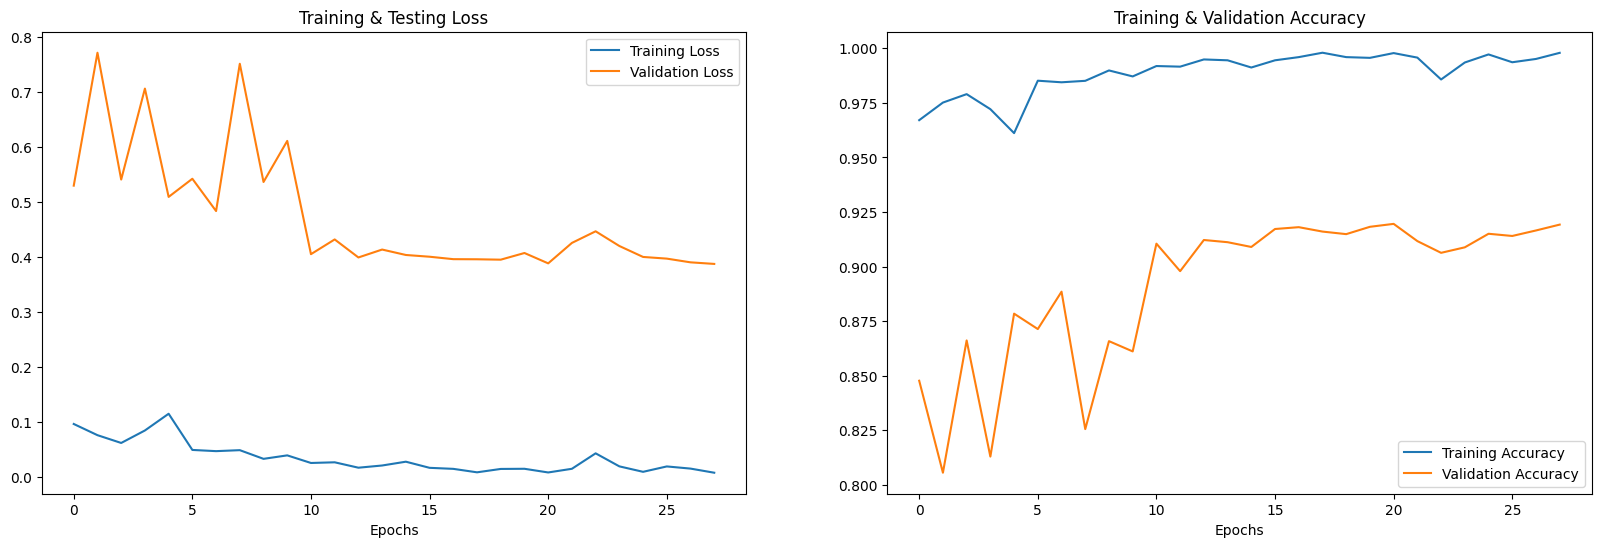

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(28)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss , label = 'Training Loss')
ax[0].plot(epochs, val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc , label = 'Training Accuracy')
ax[1].plot(epochs, val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.to_excel('df0.xlsx',index=False)
df0.head(10)


187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step


,Predicted Labels,Actual Labels
0,SAD,SAD
1,NEU,NEU
2,SAD,SAD
3,NEU,NEU
4,DIS,DIS
5,FEA,FEA
6,DIS,DIS
7,SAD,SAD
8,SAD,NEU
9,NEU,NEU


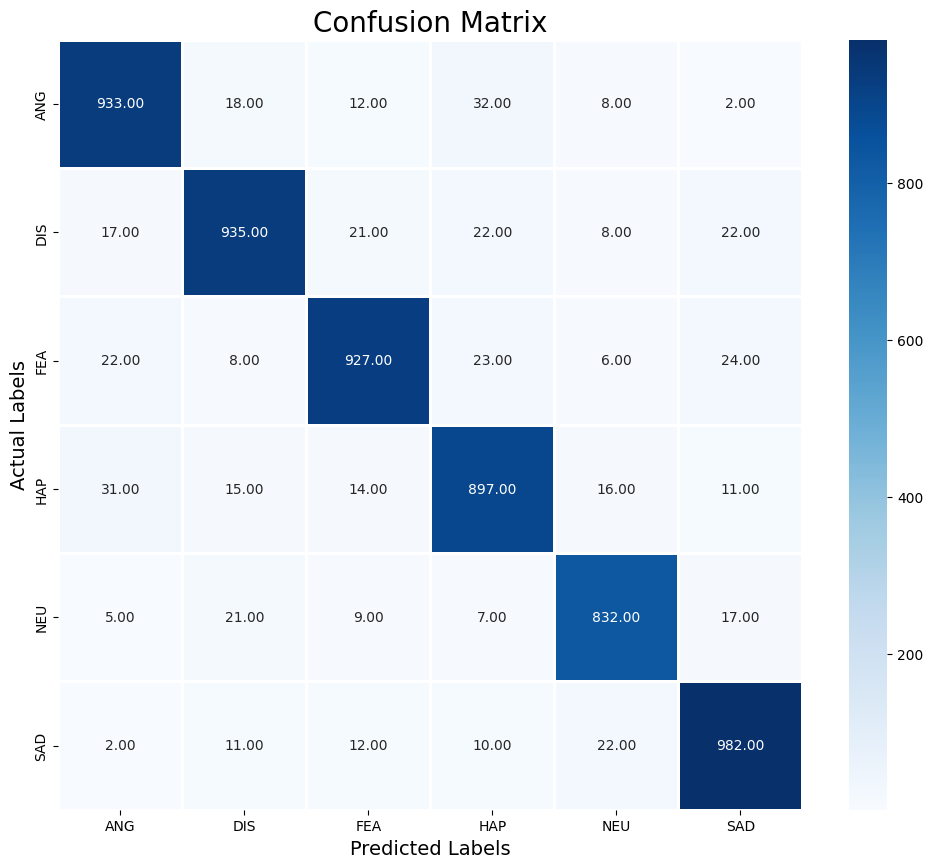

              precision    recall  f1-score   support

         ANG       0.92      0.93      0.93      1005
         DIS       0.93      0.91      0.92      1025
         FEA       0.93      0.92      0.92      1010
         HAP       0.91      0.91      0.91       984
         NEU       0.93      0.93      0.93       891
         SAD       0.93      0.95      0.94      1039

    accuracy                           0.92      5954
   macro avg       0.92      0.92      0.92      5954
weighted avg       0.92      0.92      0.92      5954



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))